[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14/demo_over_the_pole.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14/demo_over_the_pole.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14/demo_over_the_pole.ipynb)

spherical coordinate transformation example based on [Williamson and Rasch 1989](https://doi.org/10.1175/1520-0493(1989)117%3C0102:TDSLTW%3E2.0.CO;2) 
as in [Jaruga et al 2015, Fig 14](https://doi.org/10.5194/gmd-8-1005-2015)  

example controbuted to PyMPDATA by Michał Sadowski

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [23]:
import base64
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
from PyMPDATA import VectorField, ScalarField, Options, Solver, Stepper
from PyMPDATA.boundary_conditions import Periodic, Polar
from PyMPDATA_examples.utils import merge_images_into_gif
from open_atmos_jupyter_utils import show_plot

In [3]:
options = Options(n_iters=1) # TODO #120

In [4]:
nlon = 64 # original: 128
nlat = 32 # original: 64
nt = 5120/3 # original: 5120
dlmb = 2*np.pi / nlon
dphi = np.pi / nlat

r = 5/64*np.pi #  original: 7/64*n.pi
x0 = 3*np.pi / 2
y0 = 0

udt = 2*np.pi / nt
b = -np.pi / 2
h0 = 0

In [5]:
boundary_conditions = (Periodic(), Polar((nlon, nlat), 0, -1))

In [6]:
@numba.njit()
def pdf(i, j):
    tmp = 2*(
        (np.cos(dphi * (j + 0.5) - np.pi / 2) * np.sin((dlmb * (i+.5) - x0) / 2))**2 +
        np.sin((dphi * (j + 0.5) - np.pi / 2 - y0) / 2)**2
    )
    return h0 + np.where(
        # if
        tmp - r**2 <= 0,
        # then
        1 - np.sqrt(tmp)/r,
        # else
        0.
    )

In [7]:
def ad_x(i, j):
    return dlmb * udt * (
        np.cos(b) * np.cos(j * dphi - np.pi / 2) + 
        np.sin(b) * np.sin(j * dphi - np.pi / 2) * np.cos((i+.5) * dlmb)
    )

In [8]:
def ad_y(i, j):
    return -dlmb * udt * np.sin(b) * np.sin(i * dlmb)* np.cos((j+.5) * dphi - np.pi / 2)

In [9]:
advector_x = np.array([[
    ad_x(i, j)
    for j in range(nlat)] for i in range(nlon+1)])

advector_y = np.array([[
    ad_y(i, j)
    for j in range(nlat+1)] for i in range(nlon)])

-0.00036100034290834803 0.00036100034290834803


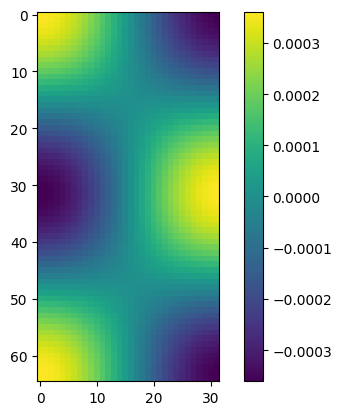

In [10]:
plt.imshow(advector_x)
plt.colorbar()
print(np.amin(advector_x), np.amax(advector_x))
np.testing.assert_array_almost_equal(advector_x[0,:], advector_x[-1,:])
show_plot(inline_format='png')

-0.00036100034290834803 0.00036100034290834803


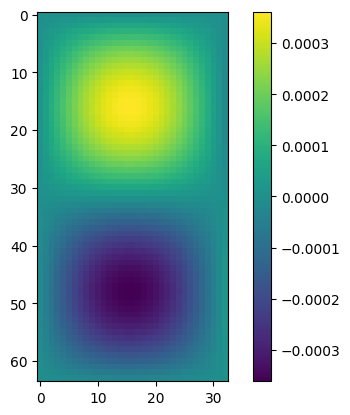

In [11]:
plt.imshow(advector_y)
plt.colorbar()
print(np.amin(advector_y), np.amax(advector_y))
np.testing.assert_array_almost_equal(advector_y[:,0], - advector_y[:,-1])
show_plot(inline_format='png')

In [12]:
advector = VectorField(
    data=(advector_x, advector_y),
    halo=options.n_halo,
    boundary_conditions=boundary_conditions    
)

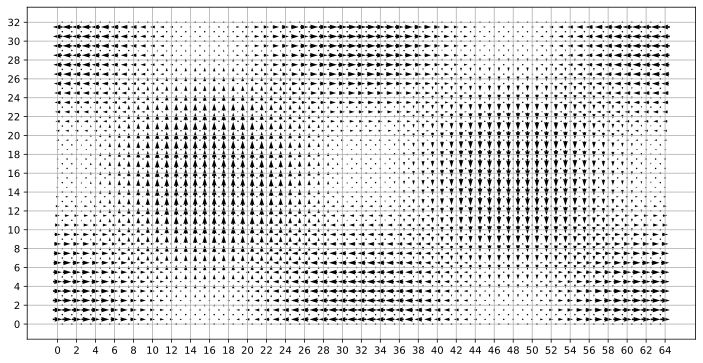

In [13]:
dx = 1
dy = 1
nx = nlon
ny = nlat

ux, uy = np.mgrid[
    0 : (nx+1)*dx : dx,
    dy/2 : ny*dy : dy
]

vx, vy = np.mgrid[
    dx/2 : nx*dx : dx,
    0: (ny+1)*dy : dy
]

fig = plt.figure(figsize=(12,6))
plt.xticks(ux[::2,0])
plt.yticks(vy[0,::2])
plt.grid()
plt.quiver(ux, uy, advector.get_component(0), 0, pivot='mid', scale=.025)
plt.quiver(vx, vy, 0, advector.get_component(1), pivot='mid', scale=.025)
show_plot()

In [14]:
@numba.njit()
def pdf_g_factor(_, y):
    return dlmb * dphi * np.cos(dphi * (y + .5) - np.pi / 2)
g_factor_z = np.array([[
    pdf_g_factor(i, j)
    for j in range(nlat)] for i in range(nlon)])

0.00047292825634092094


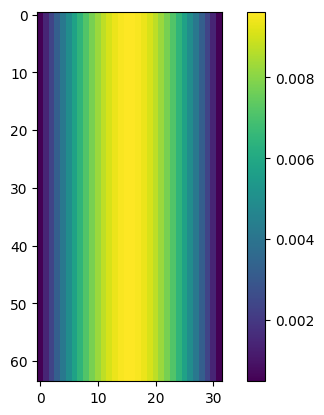

In [15]:
plt.imshow(g_factor_z)
plt.colorbar()
print(np.amin(np.abs(g_factor_z)))
show_plot(inline_format='png')

In [16]:
Cx_max = np.amax(np.abs((advector_x[1:,:]+advector_x[:-1,:])/2/g_factor_z))
print(Cx_max)
assert Cx_max < 1

0.7633300359370179


In [17]:
Cy_max = np.amax(np.abs((advector_y[:,1:]+advector_y[:,:-1])/2/g_factor_z))
print(Cy_max)
assert Cy_max < 1

0.07481942725020725


In [18]:
g_factor = ScalarField(
    data=g_factor_z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [19]:
z = np.array([[
    pdf(i, j)
    for j in range(nlat)] for i in range(nlon)])

advectee = ScalarField(
    data=z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [20]:
stepper = Stepper(options=options, n_dims=2, non_unit_g_factor=True)

In [21]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)

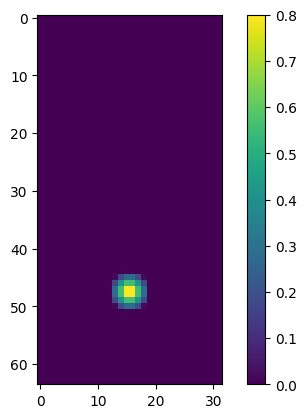

In [22]:
plt.imshow(solver.advectee.get())
plt.colorbar()
show_plot(inline_format='png')

In [24]:
states_history = [z]
for i in range(64):
    solver.advance(n_steps=128)
    states_history.append(solver.advectee.get().copy())    

# Plots 

In [25]:
theta = np.linspace(0, 1, nlat+1, endpoint=True) * np.pi
phi   = np.linspace(0, 1, nlon+1, endpoint=True) * 2 * np.pi

X = np.outer(np.sin(theta), np.cos(phi))
Y = np.outer(np.sin(theta), np.sin(phi))
Z = np.outer(np.cos(theta), np.ones(nlon+1))

def plot_state(state, save_path):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    norm = matplotlib.colors.Normalize(vmin=h0, vmax=h0+.05)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                    facecolors=matplotlib.cm.copper_r(norm(state.T)), alpha=0.6, linewidth=.75)
    m = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.copper_r, norm=norm)
    m.set_array([])
    plt.colorbar(m, shrink=.5, ax=ax)
    plt.savefig(save_path)
    plt.close()

In [26]:
!rm -rf animation
!mkdir animation
paths = []
for i, state in enumerate(states_history):
    path = f'animation/{i:03d}.png'
    paths.append(path)
    plot_state(state, path)

In [27]:
gif_path = 'animation.gif'
merge_images_into_gif("animation", gif_path, .005)


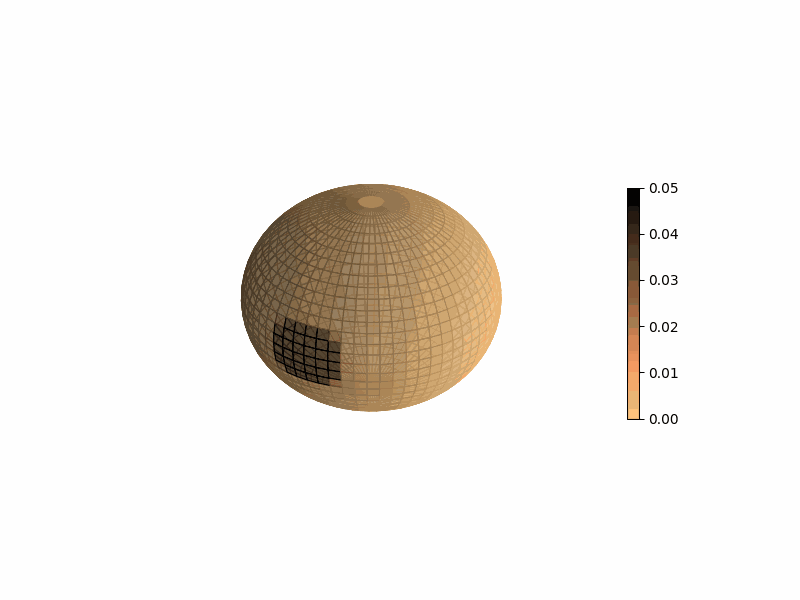

In [28]:
b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))